In [1]:
pip install python-mnist==0.5 # 다운받은 data 불러오는 라이브러리

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-mnist: filename=python_mnist-0.5-py3-none-any.whl size=11114 sha256=69e4800a65ab9f27d333f110f128deca305f90668042c59213021c8a3ad53afc
  Stored in directory: /root/.cache/pip/wheels/67/d1/46/43124d12260cf439a101157c358c8c2df565fd1744fa81a742
Successfully built python-mnist


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import random

from mnist import MNIST

import torch.utils.data as data_utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)

cpu


# Load Dataset and Preprocessing

In [4]:
mnist = MNIST("/content/drive/MyDrive/Colab Notebooks/data/raw")

x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print("x_train의 shape = {}, y_train의 shape = {}".format(x_train.shape, y_train.shape))
print("x_test의 shape = {}, y_test의 shape = {}".format(x_test.shape, y_test.shape))

x_train의 shape = (60000, 784), y_train의 shape = (60000,)
x_test의 shape = (10000, 784), y_test의 shape = (10000,)


# Convert dataset into Tensor

In [5]:
traindata = data_utils.TensorDataset(torch.FloatTensor(x_train),
                                     torch.FloatTensor(y_train))

trainloader = data_utils.DataLoader(traindata, batch_size=1000, shuffle=True, drop_last=False)

# Make Batch_Norm_Class

In [15]:
class Batch_Norm(nn.Module):
    def __init__(self):
        super(Batch_Norm, self).__init__()

        self.network = nn.Sequential(nn.Linear(784, 256),
                                     nn.BatchNorm1d(256), # 1 dimension이므로 batchnorm1d
                                     nn.ReLU(),
                                     nn.Linear(256,64),
                                     nn.BatchNorm1d(64),
                                     nn.ReLU(),
                                     nn.Linear(64,10))
        
    def forward(self, x):
      output = self.network(x)

      return output

model = Batch_Norm().to(device)

In [16]:
model

Batch_Norm(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

## Set Parameters

In [17]:
epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Data Train

In [18]:
loss_list = []

for epoch in range(epoch):
   model.train()
   average_loss = 0

   for batch_idx, (x_data, y_data) in enumerate(trainloader):
      num_of_mini_batch = len(trainloader)

      x_data = x_data.to(device)
      y_data = y_data.to(device)

      optimizer.zero_grad()

      y_predicted = model(x_data)

      y_label_long = torch.tensor(y_data, dtype=torch.long)
      y_label_long = y_label_long.to(device)

      loss = loss_function(y_predicted, y_label_long)

      loss.backward()
      optimizer.step()

      loss_list.append(loss.item())

      average_loss += (loss.item()/num_of_mini_batch)

   print("Epoch = {}\tAverage loss = {}".format((epoch+1), average_loss))
    

     

Epoch = 1	Average loss = 0.32150982134044165
Epoch = 2	Average loss = 0.09156580809503792
Epoch = 3	Average loss = 0.05845637613286575
Epoch = 4	Average loss = 0.04160033923884233
Epoch = 5	Average loss = 0.03042853884398937
Epoch = 6	Average loss = 0.02319963204984864
Epoch = 7	Average loss = 0.01794045871744553
Epoch = 8	Average loss = 0.017667425144463778
Epoch = 9	Average loss = 0.014463453864057858
Epoch = 10	Average loss = 0.0112798732239753
Epoch = 11	Average loss = 0.012509639545654252
Epoch = 12	Average loss = 0.011985722649842505
Epoch = 13	Average loss = 0.012367818388156588
Epoch = 14	Average loss = 0.013391570001840592
Epoch = 15	Average loss = 0.010755469172727315


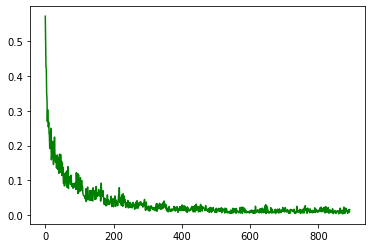

In [19]:
plt.plot(np.array(loss_list[7:]), 'g')

In [20]:
import pickle

# wb - 바이트 형식으로 저장

with open('BatchNorm.pickle', 'wb') as f:
    pickle.dump(loss_list, f)

## Test

In [21]:
test_data = data_utils.TensorDataset(torch.FloatTensor(x_test),
                                     torch.FloatTensor(y_test))

testloader = data_utils.DataLoader(test_data, batch_size=5000, shuffle=False)

In [23]:
with torch.no_grad():
  model.eval()

  num_total_data = 0
  correct = 0

  for batch_idx, (image, label) in enumerate(testloader):
    x_data = image.to(device)
    label = label.to(device)

    predict = model(x_data).to(device)

    predict_softmax = torch.nn.functional.softmax(predict)

    predict_label = torch.argmax(predict_softmax, dim=1)

    num_total_data += len(image)

    answer = sum(label==predict_label).item()

    correct += answer

  print("BatchNorm을 적용했을 때의 accuracy %.2f%%"%((correct/num_total_data)*100))


BatchNorm을 적용했을 때의 accuracy 98.13%
